# Funcs n Imports

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as sp
from scipy.stats import norm
import seaborn as sns
import statsmodels.api as sm
from scipy.stats import pearsonr
import mne

def sine_func(fs, freq, amp, time):
    samples = fs*time
    time = np.arange(samples)
    voltage = amp * np.sin(2 * np.pi * freq * time / fs)
    
    return time, voltage

# Tests #1 -- EO vs. EC, sine waves, noise

## visualizing

C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\3041233307.py:1: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set')


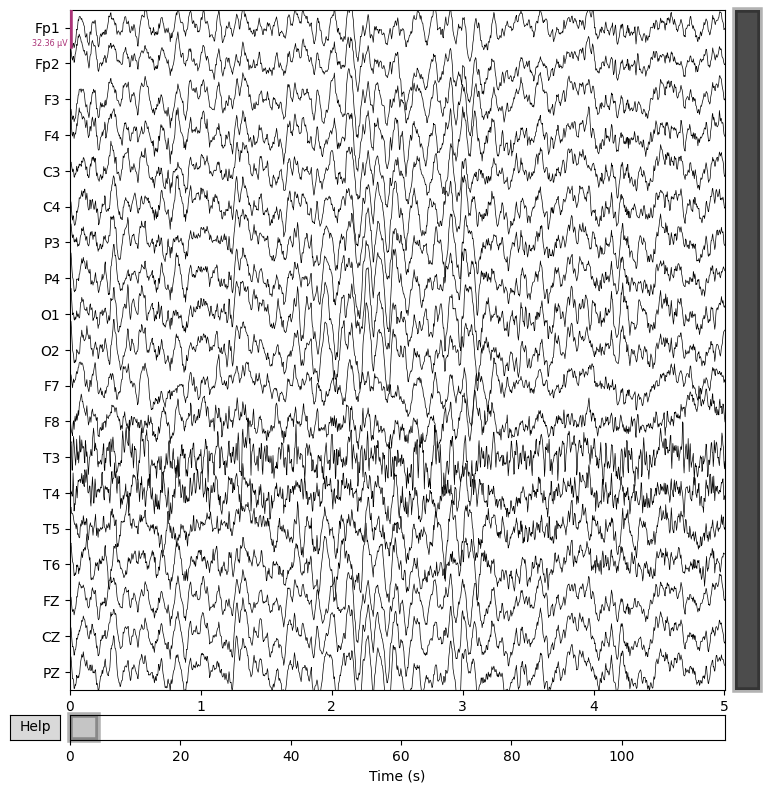

(19, 30390)


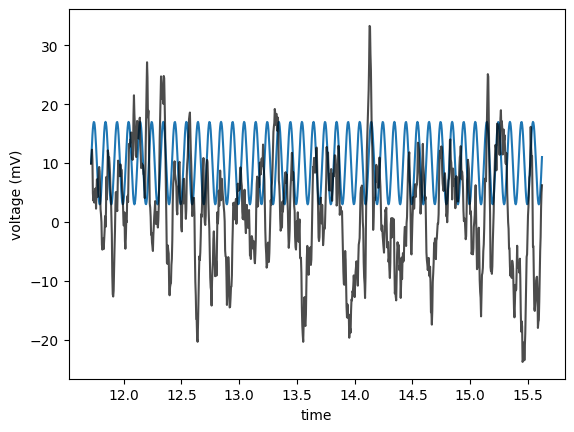

In [119]:
raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set')
fs = 256
raw_EO.plot(duration = 5, scalings = "auto")

segment = [3000, 4000] #I found a segment with no eye blinks

signal = raw_EO.get_data()
print(signal.shape)


# set the time axis
n_seconds = len(signal[0,:])/fs
times = np.arange(0, n_seconds, 1/fs)

# Plot signal segment of 1000 time points = 3.9 seconds

freq = 10 # in Hz
amp = 7 # in arbitrary units (au)
duration = (segment[1]-segment[0])/fs # in seconds

time, sine = sine_func(fs, freq, amp, duration)
sine = sine + 10 # add a DC offset

# plot some of the time series data
plt.plot(times[segment[0]:segment[1]], sine)
plt.xlabel('time')
plt.ylabel('voltage (mV)')
plt.plot(times[segment[0]:segment[1]], (signal[0,segment[0]:segment[1]]*1000000), 'k', alpha = 0.7)
plt.show()

C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\2244403658.py:1: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')


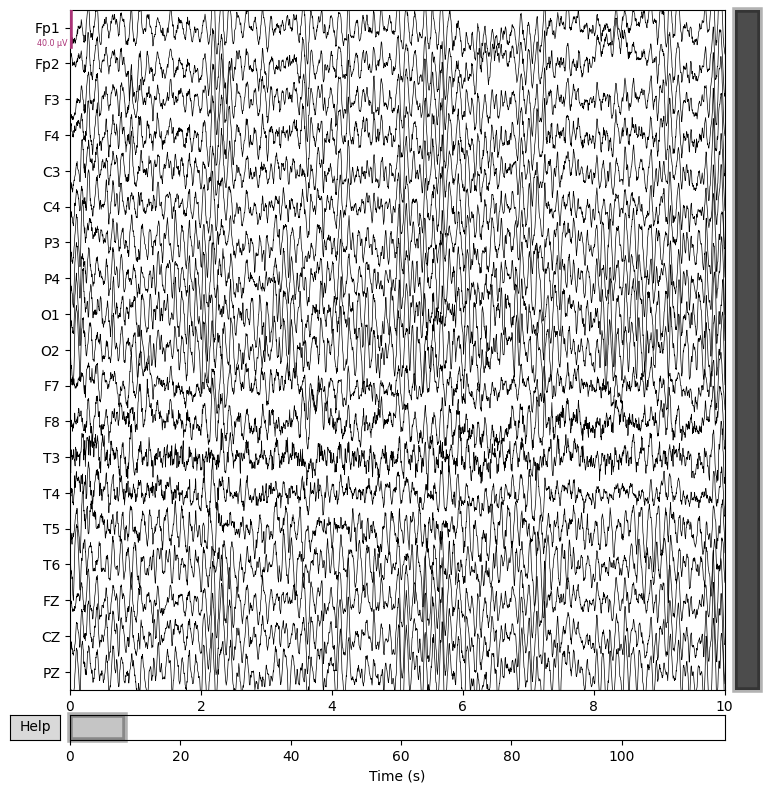

(19, 30396)
['Fp1', 'Fp2', 'F3', 'F4', 'C3', 'C4', 'P3', 'P4', 'O1', 'O2', 'F7', 'F8', 'T3', 'T4', 'T5', 'T6', 'FZ', 'CZ', 'PZ']


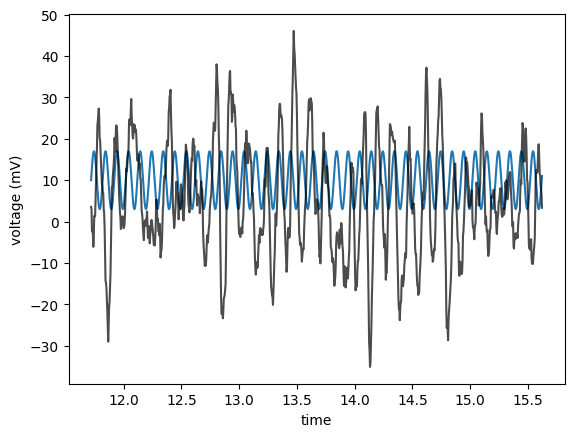

In [60]:
raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')
fs = 256
raw_EC.plot()

segment = [3000, 4000]

signal = raw_EC.get_data()
print(signal.shape)
channels = getattr(raw_EO, "ch_names")
print(channels)


# set the time axis
n_seconds = len(signal[0,:])/fs
times = np.arange(0, n_seconds, 1/fs)

# Plot signal segment of 1000 time points = 3.9 seconds

freq = 10 # in Hz
amp = 7 # in arbitrary units (au)
duration = (segment[1]-segment[0])/fs # in seconds

time, sine = sine_func(fs, freq, amp, duration)
sine = sine + 10 # add a DC offset

# plot some of the time series data
plt.plot(times[segment[0]:segment[1]], sine)
plt.xlabel('time')
plt.ylabel('voltage (mV)')
plt.plot(times[segment[0]:segment[1]], (signal[0,segment[0]:segment[1]]*1000000), 'k', alpha = 0.7)
plt.show()

In [ ]:
signal = raw_EC.pick_channels(['O1']).get_data()[0]

plt.plot(times[segment[0]:segment[1]], sine)
plt.xlabel('time')
plt.ylabel('voltage (mV)')
plt.xlim((0,1)) # just plot the first second
plt.plot(times[segment[0]:segment[1]], (signal[segment[0]:segment[1]]*1000000-30), 'k', alpha = 0.7)
plt.show()


## Irrev EO/EC

### my data

#### tau 5

In [109]:
# Whole time series -- 30390 time points
raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set', verbose = False)

channels = getattr(raw_EO, "ch_names")
n_channels = len(channels)
tau = 5
time_points = len(raw_EO)
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EO.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))


#EC
raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set', verbose = False)

channels = getattr(raw_EC, "ch_names")
n_channels = len(channels)
tau = 5
time_points = len(raw_EC.get_data()[1])
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EC.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))

C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\1192264854.py:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set', verbose = False)


30390


EO irrev: 0.0018712271773607461
30396


C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\1192264854.py:30: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set', verbose = False)


EC irrev: 0.0023401196084491473


In [110]:
# 3000 - 4000 timepoints
raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set')


forw_data = raw_EO.get_data()
forw_data = forw_data[:,3000:4000]
rev_data = np.flip(forw_data, 1)

channels = getattr(raw_EO, "ch_names")
n_channels = len(channels)
tau = 5
time_points = len(forw_data[1])
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))


# EC
raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')

forw_data = raw_EC.get_data()
forw_data = forw_data[:,3000:4000]
rev_data = np.flip(forw_data, 1)

channels = getattr(raw_EC, "ch_names")
n_channels = len(channels)
tau = 5
time_points = len(forw_data[1])
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)

print("EC irrev: " + str(irrev))

C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\418855072.py:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set')


1000
EO irrev: 0.0009019035988601
1000


C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\418855072.py:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')


EC irrev: 0.0009292849806487609


#### tau 10

In [123]:
# Whole time series -- 30390 time points
raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set', verbose = False)

channels = getattr(raw_EO, "ch_names")
n_channels = len(channels)
tau = 10
time_points = len(raw_EO)
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EO.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))


#EC
raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set', verbose = False)

channels = getattr(raw_EC, "ch_names")
n_channels = len(channels)
tau = 10
time_points = len(raw_EC.get_data()[1])
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EC.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))

C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\1941927318.py:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set', verbose = False)


30390
EO irrev: 0.00010317023632115144
30396


C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\1941927318.py:30: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set', verbose = False)


EC irrev: 0.00014061646169565914


In [122]:
# 3000 - 4000 timepoints
raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set')


forw_data = raw_EO.get_data()
forw_data = forw_data[:,3000:4000]
rev_data = np.flip(forw_data, 1)

channels = getattr(raw_EO, "ch_names")
n_channels = len(channels)
tau = 10
time_points = len(forw_data[1])
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))


# EC
raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')

forw_data = raw_EC.get_data()
forw_data = forw_data[:,3000:4000]
rev_data = np.flip(forw_data, 1)

channels = getattr(raw_EC, "ch_names")
n_channels = len(channels)
tau = 10
time_points = len(forw_data[1])
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)

print("EC irrev: " + str(irrev))

C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\2716352914.py:2: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelEOxdf.set')


1000
EO irrev: 7.313929514689537e-05
1000


C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\2716352914.py:32: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')


EC irrev: 0.00015590325335334423


### dataset1

In [121]:
# dataset found online -- https://openneuro.org/datasets/ds004148/versions/1.0.1

# Whole time series
raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\EOtest.set', verbose = False)
print(raw_EO.info['sfreq'])
#raw_EO.plot(scalings = "auto")
channels = getattr(raw_EO, "ch_names")

# test EO dataset
n_channels = len(channels)
tau = 5
time_points = len(raw_EO)
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EO.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))

#EC
raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\ECtest.set', verbose = False)
#raw_EC.plot()
channels = getattr(raw_EC, "ch_names")


n_channels = len(channels)
print(n_channels)
tau = 5
time_points = len(raw_EC)
print(time_points)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EC.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)

print("EC irrev: " + str(irrev))

C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\4285174207.py:4: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EO = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\EOtest.set', verbose = False)


500.0
150000
3.818808731914531e-06
EO irrev: 3.818808731914531e-06


C:\Users\jaket\AppData\Local\Temp\ipykernel_6180\4285174207.py:35: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\ECtest.set', verbose = False)


EC irrev: 2.7800954494355893e-05


### dataset2

#### Sub 1

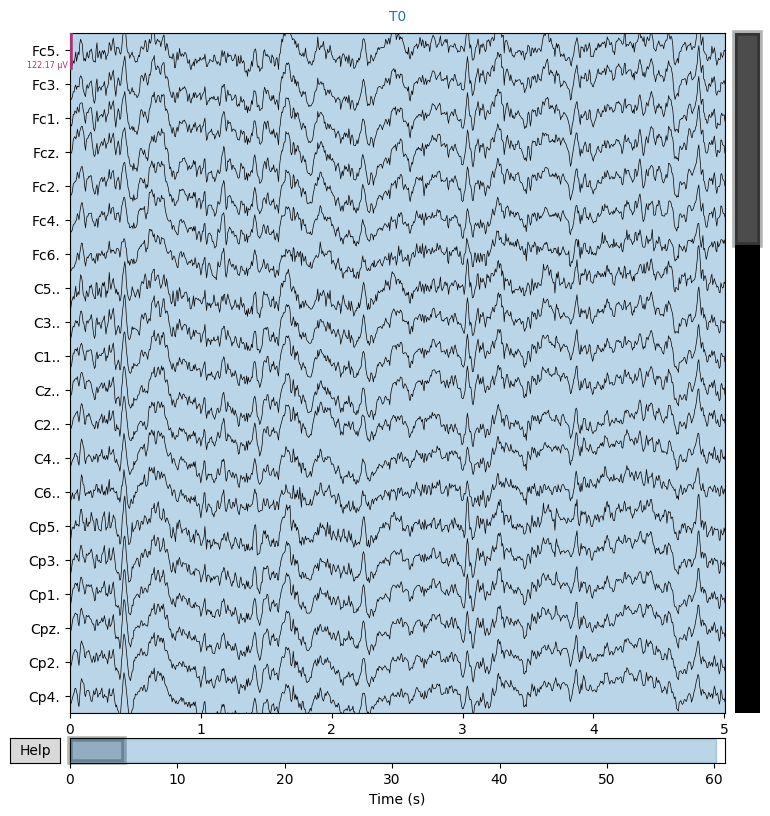

number channels: 64
number time points: 9760
EO irrev: 0.000629353652020185


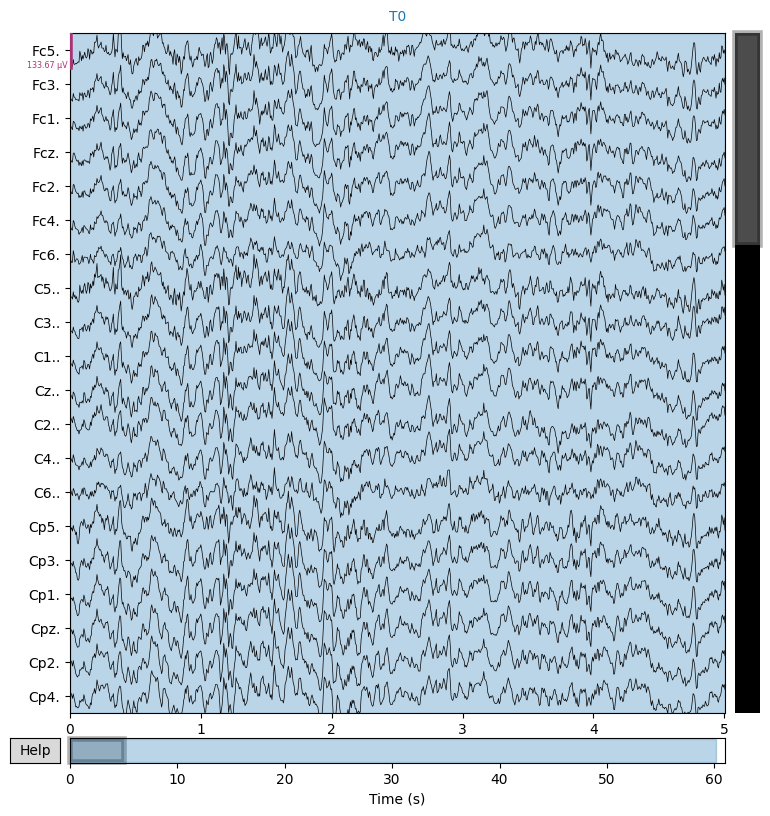

number channels: 64
number time points: 9760
EC irrev: 0.00021214936554135138


In [117]:
s1_EO = mne.io.read_raw_edf(r'C:\Users\jaket\COGS280\previous\S001R01.edf', verbose = False)
channels = getattr(s1_EO, "ch_names")


s1_EO.plot(duration = 5, scalings = "auto")
n_channels = len(channels)
print("number channels: " + str(n_channels))
tau = 5
time_points = len(s1_EO)
print("number time points: " + str(time_points))
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = s1_EO.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))

### EC 
s1_EC = mne.io.read_raw_edf(r'C:\Users\jaket\COGS280\previous\S001R02.edf', verbose = False)
channels = getattr(s1_EO, "ch_names")

s1_EC.plot(duration = 5, scalings = "auto")
n_channels = len(channels)
print("number channels: " + str(n_channels))
tau = 5
time_points = len(s1_EC)
print("number time points: " + str(time_points))
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = s1_EC.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))


#### Sub 2

In [115]:
s1_EO = mne.io.read_raw_edf(r'C:\Users\jaket\COGS280\previous\S002R01.edf', verbose = False)
channels = getattr(s1_EO, "ch_names")


#s1_EO.plot(duration = 5, scalings = "auto")
n_channels = len(channels)
print("number channels: " + str(n_channels))
tau = 5
time_points = len(s1_EO)
print("number time points: " + str(time_points))
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = s1_EO.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))

### EC 
s1_EC = mne.io.read_raw_edf(r'C:\Users\jaket\COGS280\previous\S002R02.edf', verbose = False)
channels = getattr(s1_EO, "ch_names")

#s1_EC.plot(duration = 5, scalings = "auto")
n_channels = len(channels)
print("number channels: " + str(n_channels))
tau = 5
time_points = len(s1_EC)
print("number time points: " + str(time_points))
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = s1_EC.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))


number channels: 64
number time points: 9760


EO irrev: 0.00025387099746488684
number channels: 64
number time points: 9760
EC irrev: 0.0002867474043719831


#### Sub 3

In [114]:
s1_EO = mne.io.read_raw_edf(r'C:\Users\jaket\COGS280\previous\S003R01.edf', verbose = False)
channels = getattr(s1_EO, "ch_names")


#s1_EO.plot(duration = 5, scalings = "auto")
n_channels = len(channels)
print("number channels: " + str(n_channels))
tau = 5
time_points = len(s1_EO)
print("number time points: " + str(time_points))
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = s1_EO.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))

### EC 
s1_EC = mne.io.read_raw_edf(r'C:\Users\jaket\COGS280\previous\S003R02.edf', verbose = False)
channels = getattr(s1_EO, "ch_names")

#s1_EC.plot(duration = 5, scalings = "auto")
n_channels = len(channels)
print("number channels: " + str(n_channels))
tau = 5
time_points = len(s1_EC)
print("number time points: " + str(time_points))
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = s1_EC.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))


number channels: 64
number time points: 9760
EO irrev: 0.001880119097432811
number channels: 64
number time points: 9760
EC irrev: 0.0002176784167757641


### dataset3

#### sub 1

In [99]:
import scipy.io

EO1 = scipy.io.loadmat(r'C:\Users\jaket\COGS280\previous\S02_restingPre_EO.mat')
data_EO1 = EO1['dataRest'][0:64,:]
print(data_EO1.shape)

montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw_EO1 = mne.io.RawArray(data_EO1, info, verbose = False)

#raw.plot(duration = 5, scalings = "auto")
n_channels = len(channel_names)
tau = 5
time_points = len(data_EO1[1])
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EO1.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))

### EC 
EC1 = scipy.io.loadmat(r'C:\Users\jaket\COGS280\previous\S02_restingPre_EC.mat')
data_EC1 = EC1['dataRest'][0:64,:]
print(data_EC1.shape)

montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw_EC1 = mne.io.RawArray(data_EC1, info, verbose = False)

#raw.plot(duration = 5, scalings = "auto")
n_channels = len(channel_names)
tau = 5
time_points = len(data_EC1[1])
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EC1.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))

(64, 38401)
38401
EO irrev: 1.61551364168972e-06
(64, 38401)
38401
EC irrev: 5.2648854695200595e-06


#### sub 2

In [100]:
import scipy.io

EO1 = scipy.io.loadmat(r'C:\Users\jaket\COGS280\previous\S03_restingPre_EO.mat')
data_EO1 = EO1['dataRest'][0:64,:]
print(data_EO1.shape)

montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw_EO1 = mne.io.RawArray(data_EO1, info, verbose = False)

#raw.plot(duration = 5, scalings = "auto")
n_channels = len(channel_names)
tau = 5
time_points = len(data_EO1[1])
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EO1.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))

### EC 
EC1 = scipy.io.loadmat(r'C:\Users\jaket\COGS280\previous\S03_restingPre_EC.mat')
data_EC1 = EC1['dataRest'][0:64,:]
print(data_EC1.shape)

montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw_EC1 = mne.io.RawArray(data_EC1, info, verbose = False)

#raw.plot(duration = 5, scalings = "auto")
n_channels = len(channel_names)
tau = 5
time_points = len(data_EC1[1])
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EC1.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))

(64, 38401)
EO irrev: 8.300733207168032e-06
(64, 38401)
EC irrev: 1.4947304684848226e-05


#### sub 3

In [101]:
import scipy.io

EO1 = scipy.io.loadmat(r'C:\Users\jaket\COGS280\previous\S04_restingPre_EO.mat')
data_EO1 = EO1['dataRest'][0:64,:]
print(data_EO1.shape)

montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw_EO1 = mne.io.RawArray(data_EO1, info, verbose = False)

#raw.plot(duration = 5, scalings = "auto")
n_channels = len(channel_names)
tau = 5
time_points = len(data_EO1[1])
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EO1.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EO irrev: " + str(irrev))

### EC 
EC1 = scipy.io.loadmat(r'C:\Users\jaket\COGS280\previous\S04_restingPre_EC.mat')
data_EC1 = EC1['dataRest'][0:64,:]
print(data_EC1.shape)

montage = mne.channels.make_standard_montage('biosemi64')
channel_names = montage.ch_names
channel_locs = montage.get_positions()['ch_pos']
info = mne.create_info(channel_names, sfreq=256, ch_types='eeg')
info.set_montage(montage) # Adjust accordingly
raw_EC1 = mne.io.RawArray(data_EC1, info, verbose = False)

#raw.plot(duration = 5, scalings = "auto")
n_channels = len(channel_names)
tau = 5
time_points = len(data_EC1[1])
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EC1.get_data()
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print("EC irrev: " + str(irrev))

(64, 38401)
EO irrev: 2.1282356506501292e-05
(64, 38401)
EC irrev: 3.8874028699756175e-05


## Irrev Sine wave -- 30390 time points

In [19]:
fs = 256 # sampling rate
time_points = len(raw_EC)

freq = 10 # in Hz
amp = 7 # in arbitrary units (au)
duration = time_points/fs # in seconds

time, sine = sine_func(fs, freq, amp, duration)
sine = sine + 10 # add a DC offset


all_alpha = np.tile(sine, (19, 1))

n_channels = 19
tau = 5
time_points = len(raw_EC)

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = all_alpha
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print(irrev)
print(stationarity)

0.0
0.0


## Irrev Noise -- 30390 time points

In [21]:


fs = 256 # sampling rate
time_points = len(raw_EC)

noise = np.random.randn(19, time_points)
print(noise.shape)
print(noise)

n_channels = 19
tau = 5
time_points = len(raw_EC)

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = noise
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = (Forw - Rev)**2
irrev = np.mean(ref_matrix)
stationarity = np.std(ref_matrix)
print(irrev)
print(stationarity)

(19, 30396)
[[ 0.84253608  0.51309825 -1.85436437 ...  0.04137831  2.54420822
  -0.56960325]
 [-1.21138314 -0.99493876  0.28392852 ...  1.65763319  0.97838843
   0.88656483]
 [-1.43733152  1.35496007  0.20090736 ...  0.86104502  0.25005866
  -0.65470277]
 ...
 [-1.90197437  0.52923202  0.36952315 ...  0.86175485 -1.12764356
   0.56448514]
 [ 0.40698159  0.19303318  0.21357798 ...  1.96171985 -1.95433684
   2.80365512]
 [ 1.52628162 -0.52300772  0.19188068 ... -0.45922994 -1.55818955
   1.82303142]]
7.810457179503018e-10
1.8840073147312893e-09


# Tests #2 -- window size

In [3]:
Ref_mat_arr = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_ref_matrices.npy')
irrev_arr = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_irrev_array.npy')
ref_matrix = Ref_mat_arr[0,:,:]
i = np.mean(ref_matrix)
print("First irrev value: " + str(i))
print(irrev_arr[0])
print("First ref matrix: " + str(ref_matrix))

data = np.load(r'C:\Users\jaket\COGS280\DataDeco\eeg.npy')

First irrev value: 0.0025118690801029463
0.0025118690801029463
First ref matrix: [[0.00000000e+00 6.74746854e-04 2.30638243e-04 ... 2.78677172e-04
  1.27150470e-06 1.58245844e-08]
 [6.74746854e-04 0.00000000e+00 2.14187754e-07 ... 9.90000962e-04
  1.75220518e-04 2.52771564e-04]
 [2.30638243e-04 2.14187754e-07 0.00000000e+00 ... 1.03641999e-05
  8.29746218e-07 1.75973129e-06]
 ...
 [2.78677172e-04 9.90000962e-04 1.03641999e-05 ... 0.00000000e+00
  1.38149459e-04 1.84498055e-04]
 [1.27150470e-06 1.75220518e-04 8.29746218e-07 ... 1.38149459e-04
  0.00000000e+00 1.34084674e-05]
 [1.58245844e-08 2.52771564e-04 1.75973129e-06 ... 1.84498055e-04
  1.34084674e-05 0.00000000e+00]]


## shortening time window for same trial (prestim) (4/23)

Trial number: 0
Trial number: 1
Trial number: 2
Trial number: 3
Trial number: 4
Trial number: 5
Trial number: 6
Trial number: 7
Trial number: 8
Trial number: 9
Trial number: 10
Trial number: 11
Trial number: 12
Trial number: 13
Trial number: 14
Trial number: 15
Trial number: 16
Trial number: 17
Trial number: 18
Trial number: 19
Trial number: 20
Trial number: 21
Trial number: 22
Trial number: 23
Trial number: 24
Trial number: 25
Trial number: 26
Trial number: 27
Trial number: 28
Trial number: 29
Trial number: 30
Trial number: 31
Trial number: 32
Trial number: 33
Trial number: 34
Trial number: 35
Trial number: 36
Trial number: 37
Trial number: 38
Trial number: 39
Trial number: 40
Trial number: 41
Trial number: 42
Trial number: 43
Trial number: 44
Trial number: 45
Trial number: 46
Trial number: 47
Trial number: 48
Trial number: 49


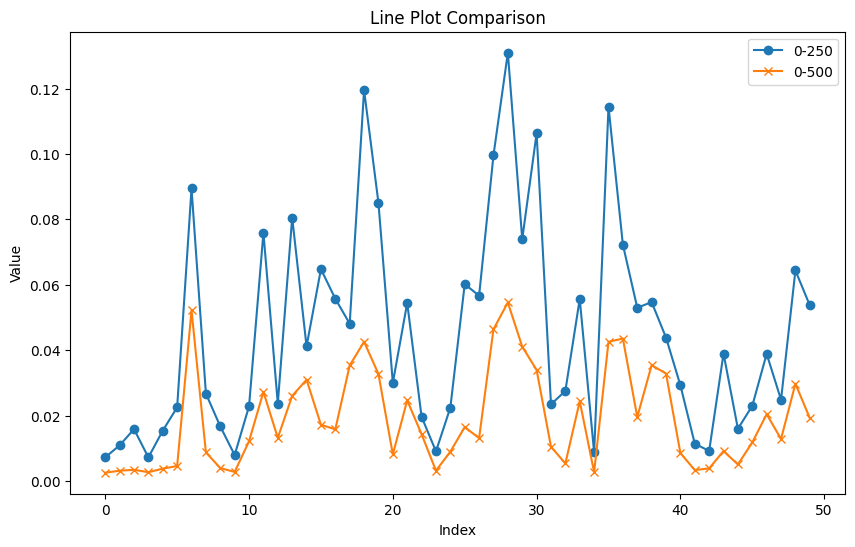

In [57]:
#0-250 ms prestimulus

tau = 5
fs = 128
number_trials = data.shape[0]

n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
ref_matrix = np.zeros((n_channels, n_channels))
Ref_matrices = []
irrev_array = np.zeros(number_trials)

forw_data = data[:,:,0:32]
rev_data = np.flip(forw_data, 2)

for trial in range(50):
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[trial,i,:-tau], forw_data[trial,j,tau:])
      y = pearsonr(rev_data[trial,i,:-tau], rev_data[trial,j,tau:])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  ref_matrix = (Forw - Rev)**2
  irrev = np.mean(ref_matrix)
  irrev_array[trial] = irrev
  Ref_matrices.append(ref_matrix)
  print(f"Trial number: {trial}")

Ref_matrices_array = np.array(Ref_matrices)



plt.figure(figsize=(10, 6))
short = irrev_array[0:50] 
long = irrev_arr[0:50] # original prestim_irrev_array
plt.plot(short, label='0-250', marker='o')
plt.plot(long, label='0-500', marker='x')
plt.title('Line Plot Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

## lengthening time window for same trial (4/29)

Trial number: 0
Trial number: 1
Trial number: 2
Trial number: 3
Trial number: 4
Trial number: 5
Trial number: 6
Trial number: 7
Trial number: 8
Trial number: 9
Trial number: 10
Trial number: 11
Trial number: 12
Trial number: 13
Trial number: 14
Trial number: 15
Trial number: 16
Trial number: 17
Trial number: 18
Trial number: 19
Trial number: 20
Trial number: 21
Trial number: 22
Trial number: 23
Trial number: 24
Trial number: 25
Trial number: 26
Trial number: 27
Trial number: 28
Trial number: 29
Trial number: 30
Trial number: 31
Trial number: 32
Trial number: 33
Trial number: 34
Trial number: 35
Trial number: 36
Trial number: 37
Trial number: 38
Trial number: 39
Trial number: 40
Trial number: 41
Trial number: 42
Trial number: 43
Trial number: 44
Trial number: 45
Trial number: 46
Trial number: 47
Trial number: 48
Trial number: 49


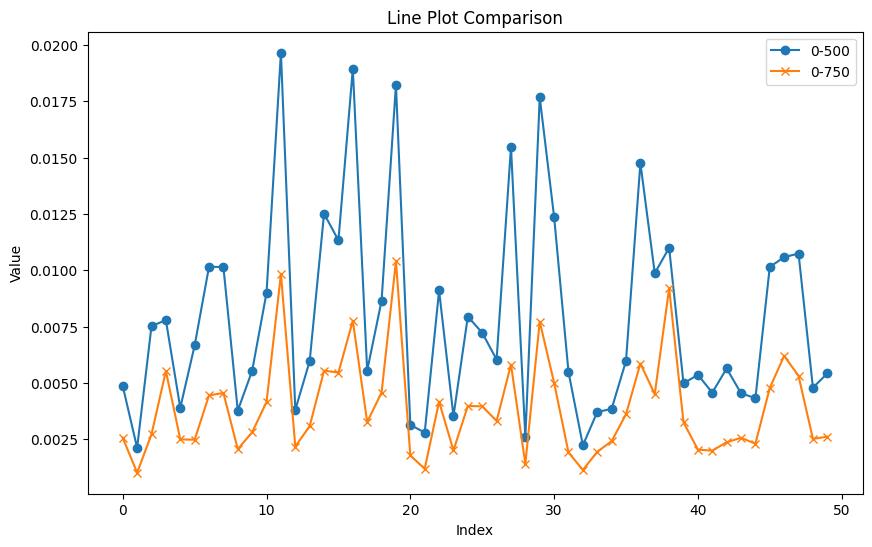

In [58]:
#0-750 ms poststimulus

tau = 5
fs = 128
number_trials = data.shape[0]

n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
ref_matrix = np.zeros((n_channels, n_channels))
Ref_matrices = []
irrev_array = np.zeros(number_trials)

forw_data = data[:,:,64:160]
rev_data = np.flip(forw_data, 2)

for trial in range(50):
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[trial,i,:-tau], forw_data[trial,j,tau:])
      y = pearsonr(rev_data[trial,i,:-tau], rev_data[trial,j,tau:])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  ref_matrix = (Forw - Rev)**2
  irrev = np.mean(ref_matrix)
  irrev_array[trial] = irrev
  Ref_matrices.append(ref_matrix)
  print(f"Trial number: {trial}")

Ref_matrices_array = np.array(Ref_matrices)

post_irrev_arr = np.load(r'C:\Users\jaket\COGS280\DataDeco\poststimulus_irrev_array.npy')

plt.figure(figsize=(10, 6))
big = 
medium = irrev_array[0:50] 
small = post_irrev_arr[0:50] # original poststim_irrev_array
plt.plot(short, label='0-250', marker='+')
plt.plot(short, label='0-500', marker='o')
plt.plot(long, label='0-750', marker='x')
plt.title('Line Plot Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

## plotted together

In [21]:
data = np.load(r'C:\Users\jaket\COGS280\DataDeco\eeg.npy')

# small 250 ms
tau = 5
fs = 128
number_trials = data.shape[0]

n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
ref_matrix = np.zeros((n_channels, n_channels))
Ref_matrices = []

small2 = []

forw_data = data[:,:,64:96]
rev_data = np.flip(forw_data, 2)

for trial in range(0,10000,100):
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[trial,i,:-tau], forw_data[trial,j,tau:])
      y = pearsonr(rev_data[trial,i,:-tau], rev_data[trial,j,tau:])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  ref_matrix = (Forw - Rev)**2
  irrev = np.mean(ref_matrix)
  small2.append(irrev)
  Ref_matrices.append(ref_matrix)
  print(f"Trial number, small: {trial}")



#big (750 ms)
tau = 5
fs = 128
number_trials = data.shape[0]

n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
ref_matrix = np.zeros((n_channels, n_channels))
Ref_matrices = []
big2 = []

forw_data = data[:,:,64:160]
rev_data = np.flip(forw_data, 2)

for trial in range(0,10000,100):
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[trial,i,:-tau], forw_data[trial,j,tau:])
      y = pearsonr(rev_data[trial,i,:-tau], rev_data[trial,j,tau:])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  ref_matrix = (Forw - Rev)**2
  irrev = np.mean(ref_matrix)
  big2.append(irrev)
  Ref_matrices.append(ref_matrix)
  print(f"Trial number, big: {trial}")



Trial number, small: 0
Trial number, small: 100
Trial number, small: 200
Trial number, small: 300
Trial number, small: 400
Trial number, small: 500
Trial number, small: 600
Trial number, small: 700
Trial number, small: 800
Trial number, small: 900
Trial number, small: 1000
Trial number, small: 1100
Trial number, small: 1200
Trial number, small: 1300
Trial number, small: 1400
Trial number, small: 1500
Trial number, small: 1600
Trial number, small: 1700
Trial number, small: 1800
Trial number, small: 1900
Trial number, small: 2000
Trial number, small: 2100
Trial number, small: 2200
Trial number, small: 2300
Trial number, small: 2400
Trial number, small: 2500
Trial number, small: 2600
Trial number, small: 2700
Trial number, small: 2800
Trial number, small: 2900
Trial number, small: 3000
Trial number, small: 3100
Trial number, small: 3200
Trial number, small: 3300
Trial number, small: 3400
Trial number, small: 3500
Trial number, small: 3600
Trial number, small: 3700
Trial number, small: 380

[0, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1100, 1200, 1300, 1400, 1500, 1600, 1700, 1800, 1900, 2000, 2100, 2200, 2300, 2400, 2500, 2600, 2700, 2800, 2900, 3000, 3100, 3200, 3300, 3400, 3500, 3600, 3700, 3800, 3900, 4000, 4100, 4200, 4300, 4400, 4500, 4600, 4700, 4800, 4900, 5000, 5100, 5200, 5300, 5400, 5500, 5600, 5700, 5800, 5900, 6000, 6100, 6200, 6300, 6400, 6500, 6600, 6700, 6800, 6900, 7000, 7100, 7200, 7300, 7400, 7500, 7600, 7700, 7800, 7900, 8000, 8100, 8200, 8300, 8400, 8500, 8600, 8700, 8800, 8900, 9000, 9100, 9200, 9300, 9400, 9500, 9600, 9700, 9800, 9900]


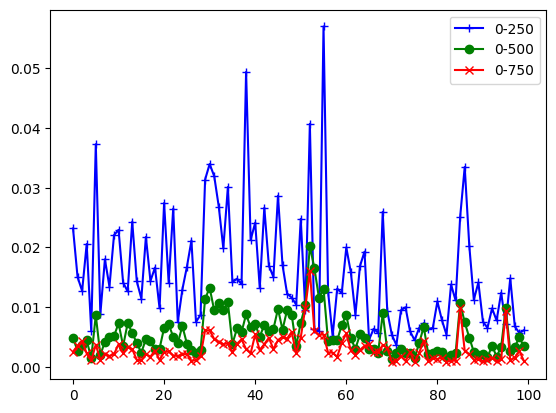

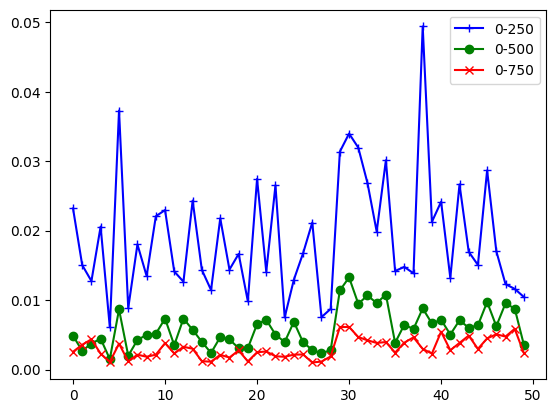

Logged:


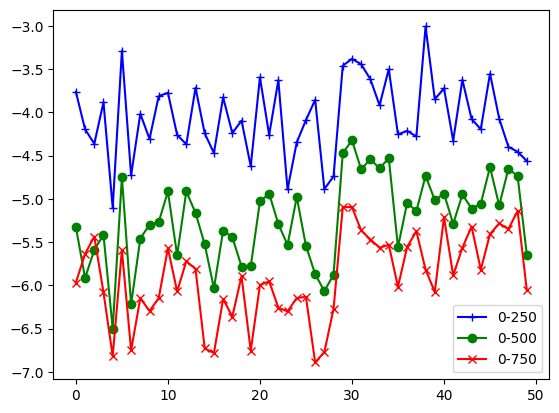

STD DEV of those trials: 
0-250 window: 0.009844865791951332
0-500 window: 0.0034485472614382605
0-750 window: 0.0022793470603391323

STD DEV of the logged trials: 
0-250 window: 0.5924855311248244
0-500 window: 0.6008474978952361
0-750 window: 0.6350012766504339


In [30]:

#medium --
irrev_arr = np.load(r'C:\Users\jaket\COGS280\DataDeco\poststimulus_irrev_array.npy')

indices = [i for i in range(10000) if i % 100 == 0]
print(indices)
big1 = big2[0:100]
medium1 = irrev_arr[indices]
small1 = small2[0:100]


plt.plot(small1, label='0-250', marker='+', color = 'blue')
plt.plot(medium1, label='0-500', marker='o', color = 'green')
plt.plot(big1, label='0-750', marker='x', color = 'red')
plt.legend()
plt.show()

plt.plot(small1[0:50], label='0-250', marker='+', color = 'blue')
plt.plot(medium1[0:50], label='0-500', marker='o', color = 'green')
plt.plot(big1[0:50], label='0-750', marker='x', color = 'red')
plt.legend()
plt.show()


print("Logged:")
plt.plot(np.log(small1[0:50]), label='0-250', marker='+', color = 'blue')
plt.plot(np.log(medium1[0:50]), label='0-500', marker='o', color = 'green')
plt.plot(np.log(big1[0:50]), label='0-750', marker='x', color = 'red')
plt.legend()
plt.show()

print("STD DEV of those trials: ")
print("0-250 window: " + str(np.std(small1[0:100])))
print("0-500 window: " + str(np.std(medium1[0:100])))
print("0-750 window: " + str(np.std(big1[0:100])))

print()
print("STD DEV of the logged trials: ")
print("0-250 window: " + str(np.std(np.log(small1[0:100]))))
print("0-500 window: " + str(np.std(np.log(medium1[0:100]))))
print("0-750 window: " + str(np.std(np.log(big1[0:100]))))

# Tests #3 -- Tau exploration

## self data, autocorrelation function

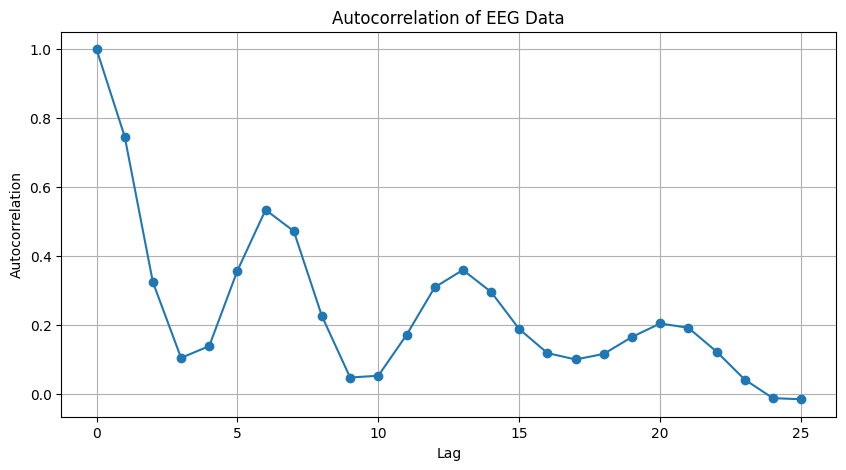

In [4]:
data = np.load(r'C:\Users\jaket\COGS280\DataDeco\eeg.npy')

def autocorrelation(x, max_lag):
    """ Compute autocorrelation using NumPy for a given max_lag """
    autocorr = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Take the second half
    autocorr /= autocorr[0]  # Normalize
    return autocorr[:max_lag+1]

max_lag = 25  # Adjust based on your data and needs
autocorr_values = autocorrelation(data[0,3,:], max_lag)

plt.figure(figsize=(10, 5))
plt.plot(autocorr_values, linestyle='-', marker='o')
plt.title('Autocorrelation of EEG Data')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

## Comparing taus for a set of irrevs

Trial number: 0
Trial number: 1
Trial number: 2
Trial number: 3
Trial number: 4
Trial number: 5
Trial number: 6
Trial number: 7
Trial number: 8
Trial number: 9
Trial number: 10
Trial number: 11
Trial number: 12
Trial number: 13
Trial number: 14
Trial number: 15
Trial number: 16
Trial number: 17
Trial number: 18
Trial number: 19
Trial number: 20
Trial number: 21
Trial number: 22
Trial number: 23
Trial number: 24
Trial number: 25
Trial number: 26
Trial number: 27
Trial number: 28
Trial number: 29
Trial number: 30
Trial number: 31
Trial number: 32
Trial number: 33
Trial number: 34
Trial number: 35
Trial number: 36
Trial number: 37
Trial number: 38
Trial number: 39
Trial number: 40
Trial number: 41
Trial number: 42
Trial number: 43
Trial number: 44
Trial number: 45
Trial number: 46
Trial number: 47
Trial number: 48
Trial number: 49


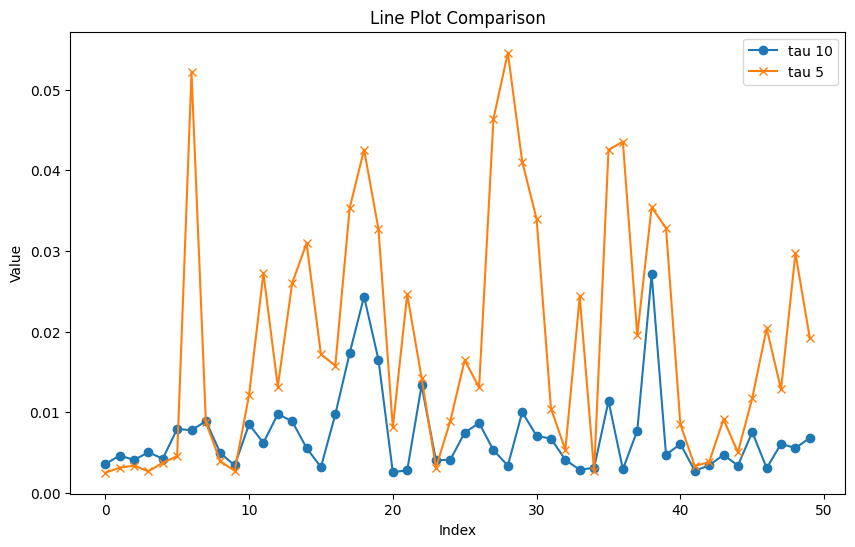

In [5]:
behavior = pd.read_csv(r'C:\Users\jaket\COGS280\DataDeco\behavior.csv', index_col=0).reset_index(drop=True)

prestimulus_irrev_array = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_irrev_array.npy')
prestim_alpha_power = np.load(r'C:\Users\jaket\COGS280\DataDeco\prestimulus_mean_alphapower.npy')
behavior['trial'] = behavior.index
behavior['prestimulus_irreversibility'] = prestimulus_irrev_array
behavior['alpha_power'] = prestim_alpha_power

#tau 10

tau = 10
fs = 128
number_trials = data.shape[0]
n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
ref_matrix = np.zeros((n_channels, n_channels))
Ref_matrices = []
irrev_array = np.zeros(number_trials)

forw_data = data[:,:,0:64]
rev_data = np.flip(forw_data, 2)

for trial in range(50):
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[trial,i,:-tau], forw_data[trial,j,tau:])
      y = pearsonr(rev_data[trial,i,:-tau], rev_data[trial,j,tau:])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  ref_matrix = (Forw - Rev)**2
  irrev = np.mean(ref_matrix)
  irrev_array[trial] = irrev
  Ref_matrices.append(ref_matrix)
  print(f"Trial number: {trial}")

Ref_matrices_array = np.array(Ref_matrices)



plt.figure(figsize=(10, 6))
short = irrev_array[0:50] 
long = behavior['prestimulus_irreversibility'][0:50] # original prestim_irrev_array tau 5
plt.plot(short, label='tau 10', marker='o')
plt.plot(long, label='tau 5', marker='x')
plt.title('Line Plot Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

Trial number: 0
Trial number: 1
Trial number: 2
Trial number: 3
Trial number: 4
Trial number: 5
Trial number: 6
Trial number: 7
Trial number: 8
Trial number: 9
Trial number: 10
Trial number: 11
Trial number: 12
Trial number: 13
Trial number: 14
Trial number: 15
Trial number: 16
Trial number: 17
Trial number: 18
Trial number: 19
Trial number: 20
Trial number: 21
Trial number: 22
Trial number: 23
Trial number: 24
Trial number: 25
Trial number: 26
Trial number: 27
Trial number: 28
Trial number: 29
Trial number: 30
Trial number: 31
Trial number: 32
Trial number: 33
Trial number: 34
Trial number: 35
Trial number: 36
Trial number: 37
Trial number: 38
Trial number: 39
Trial number: 40
Trial number: 41
Trial number: 42
Trial number: 43
Trial number: 44
Trial number: 45
Trial number: 46
Trial number: 47
Trial number: 48
Trial number: 49


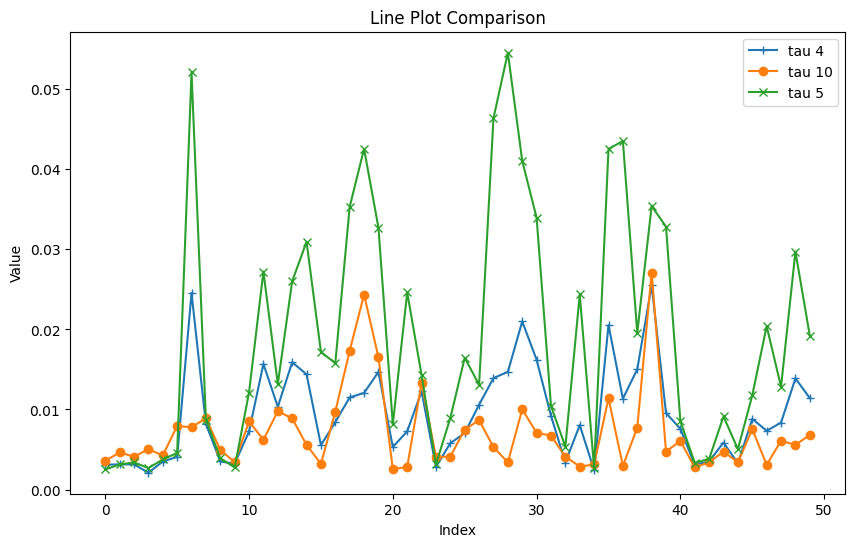

In [6]:
#0-250 ms prestimulus

tau = 4
fs = 128
number_trials = data.shape[0]
n_channels = len(data[0,:,0])

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))
ref_matrix = np.zeros((n_channels, n_channels))
Ref_matrices = []
irrev_array1 = np.zeros(number_trials)

forw_data = data[:,:,0:64]
rev_data = np.flip(forw_data, 2)

for trial in range(50):
  for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[trial,i,:-tau], forw_data[trial,j,tau:])
      y = pearsonr(rev_data[trial,i,:-tau], rev_data[trial,j,tau:])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
  Forw = -1/2 * np.log(1 - (Forw**2))
  Rev = -1/2 * np.log(1 - (Rev**2))
  ref_matrix = (Forw - Rev)**2
  irrev = np.mean(ref_matrix)
  irrev_array1[trial] = irrev
  Ref_matrices.append(ref_matrix)
  print(f"Trial number: {trial}")

plt.figure(figsize=(10, 6))
short = irrev_array[0:50] 
long = behavior['prestimulus_irreversibility'][0:50]
shorter = irrev_array1[0:50] # original prestim_irrev_array tau 5
plt.plot(shorter, label='tau 4', marker='+')
plt.plot(short, label='tau 10', marker='o')
plt.plot(long, label='tau 5', marker='x')
plt.title('Line Plot Comparison')
plt.xlabel('Index')
plt.ylabel('Value')
plt.legend()
plt.show()

# Tests #4

In [11]:
from scipy.signal import sosfiltfilt, butter, hilbert
from scipy import io

from pingouin import circ_corrcl

def butter_bandpass(data, fs, filt_freq, order):
    # make sure that the user provides two frequencies for bandpass filter
    try:
        # renormalize frequencies in Hz to fractional scale required by butter
        nyq = 0.5 * fs # nyquist frequency
        f0 = (filt_freq[0]/nyq)
        f1 = (filt_freq[1]/nyq)

        # highpass first
        sos = butter(order, f0, btype = 'high', analog=False, output='sos')
        y = sosfiltfilt(sos, data)

        # then lowpass
        sos = butter(order, f1, btype = 'low', analog=False, output='sos')
        y = sosfiltfilt(sos, y)
        
        return y
    
    except:
        print("filt_freq must have two frequencies for a bandpass filter")

c:\Users\jaket\anaconda3\envs\deco1\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package outdated is out of date. Your version is 0.2.1, the latest is 0.2.2.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(
c:\Users\jaket\anaconda3\envs\deco1\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.1, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


C:\Users\jaket\AppData\Local\Temp\ipykernel_38440\3055565824.py:1: RuntimeWarning: Data will be preloaded. preload=False or a string preload is not supported when the data is stored in the .set file
  raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')


(19, 30396)


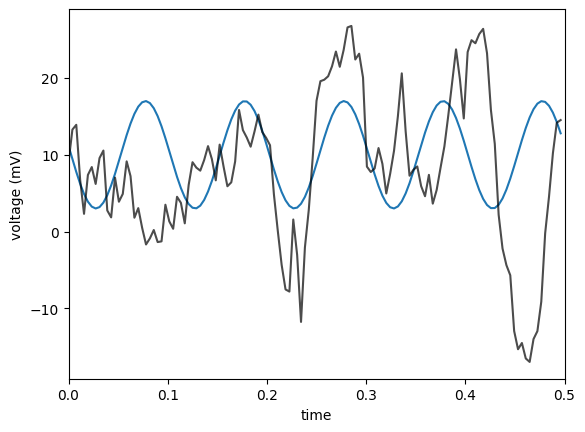

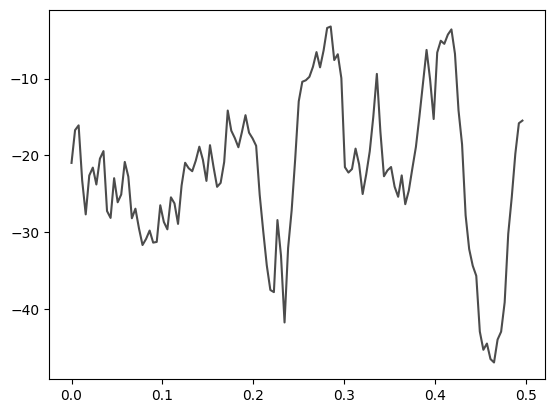

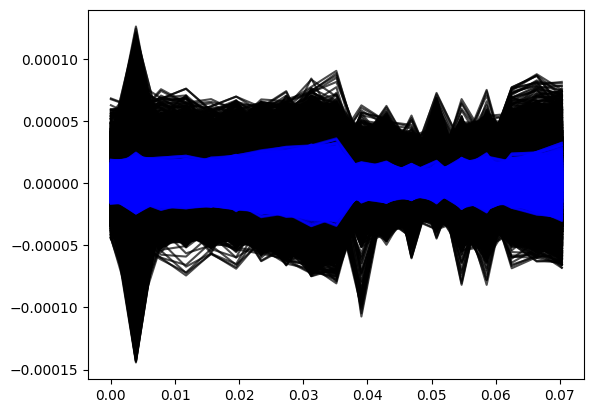

In [13]:
raw_EC = mne.io.read_raw_eeglab(r'C:\Users\jaket\COGS280\previous\MichaelECxdf.set')
fs = 256
timepoints = 128
segment = [0, 128]

signal = raw_EC.get_data()
print(signal.shape)


# set the time axis
n_seconds = timepoints/fs
times = np.arange(0, n_seconds, 1/fs)


# plot some of the time series data
plt.plot(times[segment[0]:segment[1]], sine)
plt.xlabel('time')
plt.ylabel('voltage (mV)')
plt.xlim((0,0.5)) # just plot the first second
plt.plot(times[segment[0]:segment[1]], (signal[10,segment[0]:segment[1]]*1000000), 'k', alpha = 0.7)
plt.show()

# Define the frequency band of interest
fs = 256
alpha_range = [8, 12]
n_seconds = len(signal)/fs
times = np.arange(0, n_seconds, 1/fs)

# Bandpass filter the data
alpha_signal = butter_bandpass(signal, fs=fs, filt_freq=alpha_range, order=3)

plt.plot(times[segment[0]:segment[1]], signal[segment[0]:segment[1]], 'k', alpha = 0.7)
plt.plot(times[segment[0]:segment[1]], alpha_signal[segment[0]:segment[1]], 'b', alpha = 0.7)

plt.show()

In [14]:
from scipy.stats import pearsonr

channels = getattr(raw_EC, "ch_names")


n_channels = len(channels)
tau = 13
time_points = len(raw_EC)
Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = raw_EC.get_data()
rev_data = np.flip(forw_data, 1)


for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:time_points-tau], forw_data[j,tau:time_points])
      y = pearsonr(rev_data[i,0:time_points-tau], rev_data[j,tau:time_points])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
irrev = np.mean((Forw - Rev)**2)
print(irrev)

0.00030303103303322773


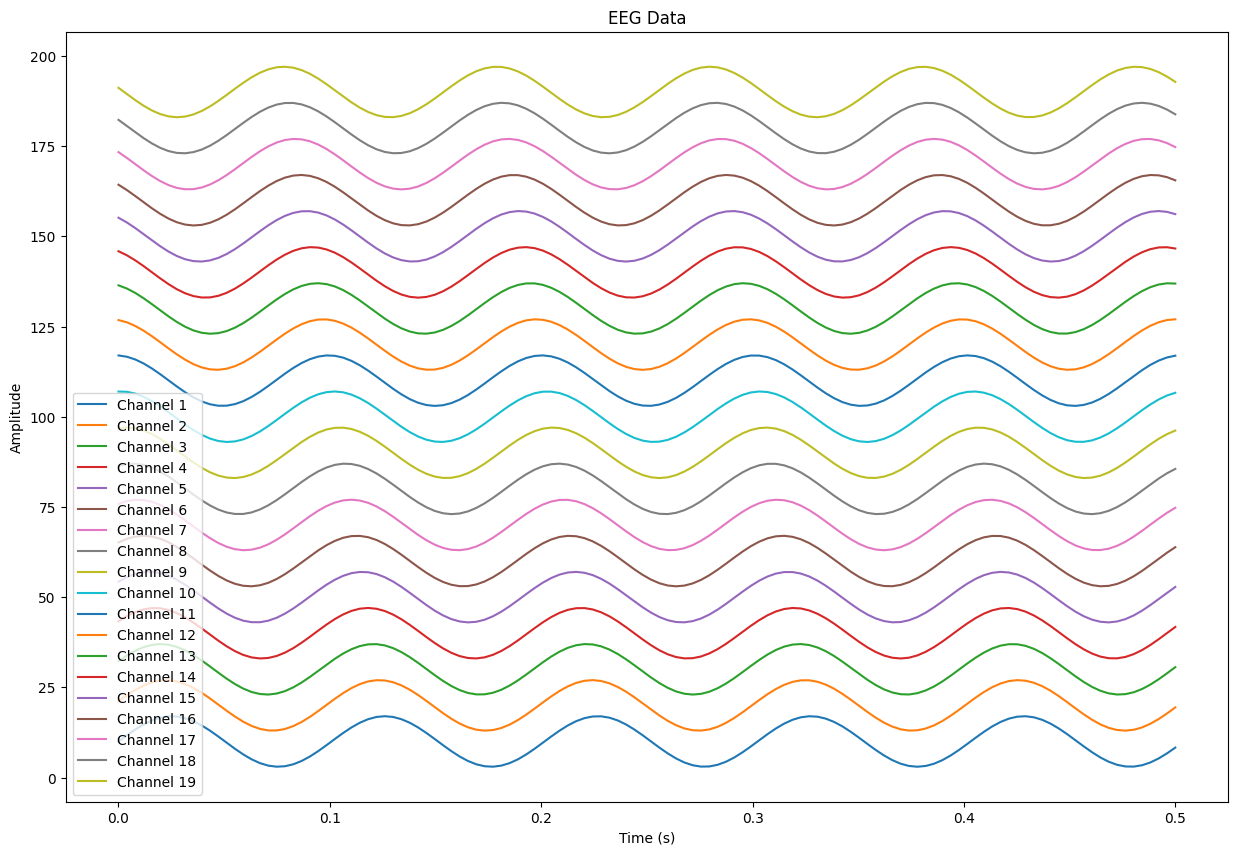

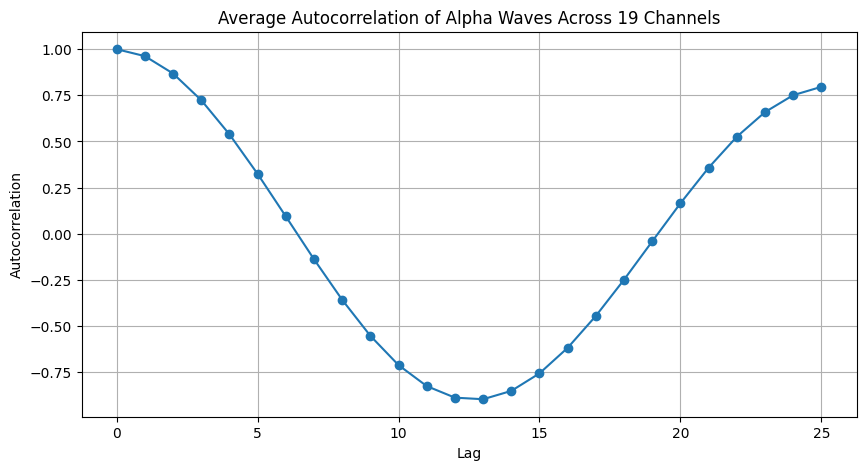

Irrev-- linear phase increment alpha without noise!: 0.05422992979414659


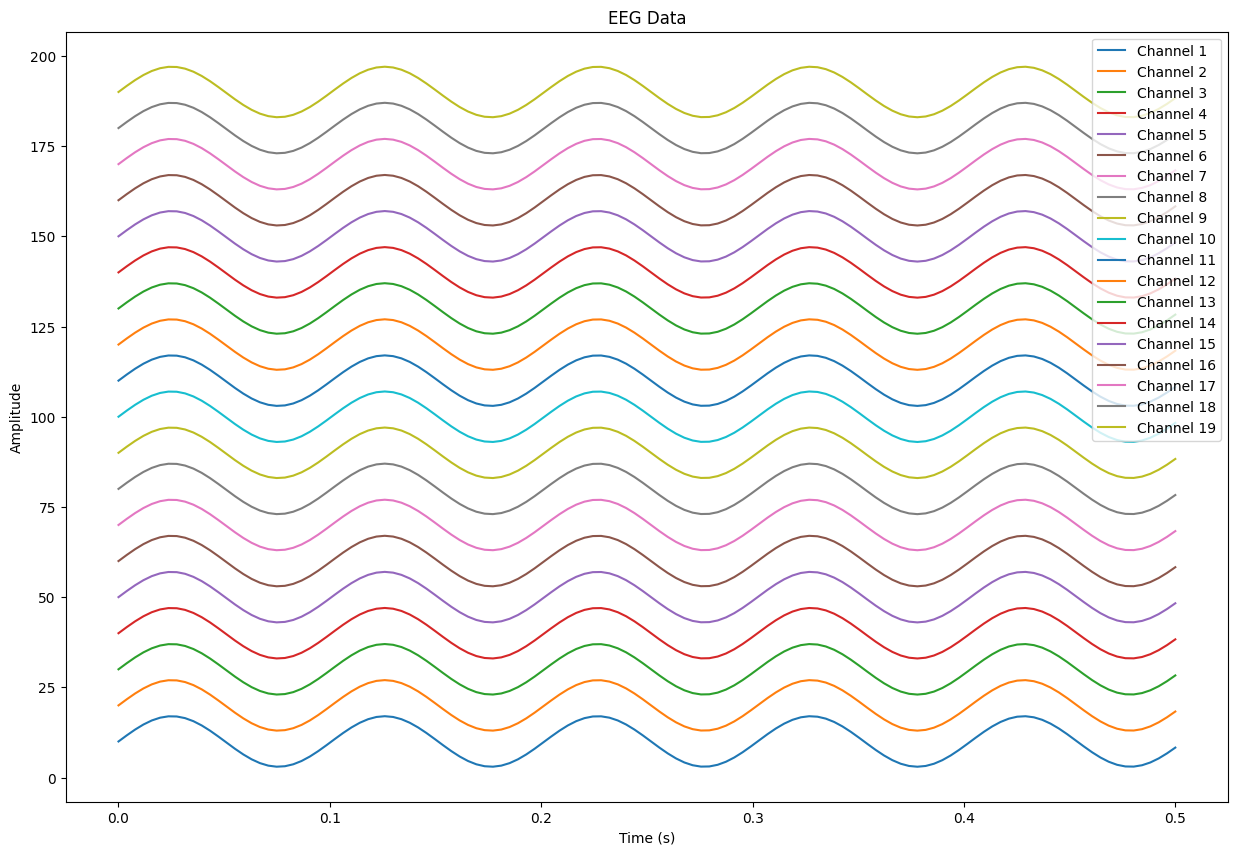

Irrev-- perfect zero phase lag alpha no noise!: 0.0


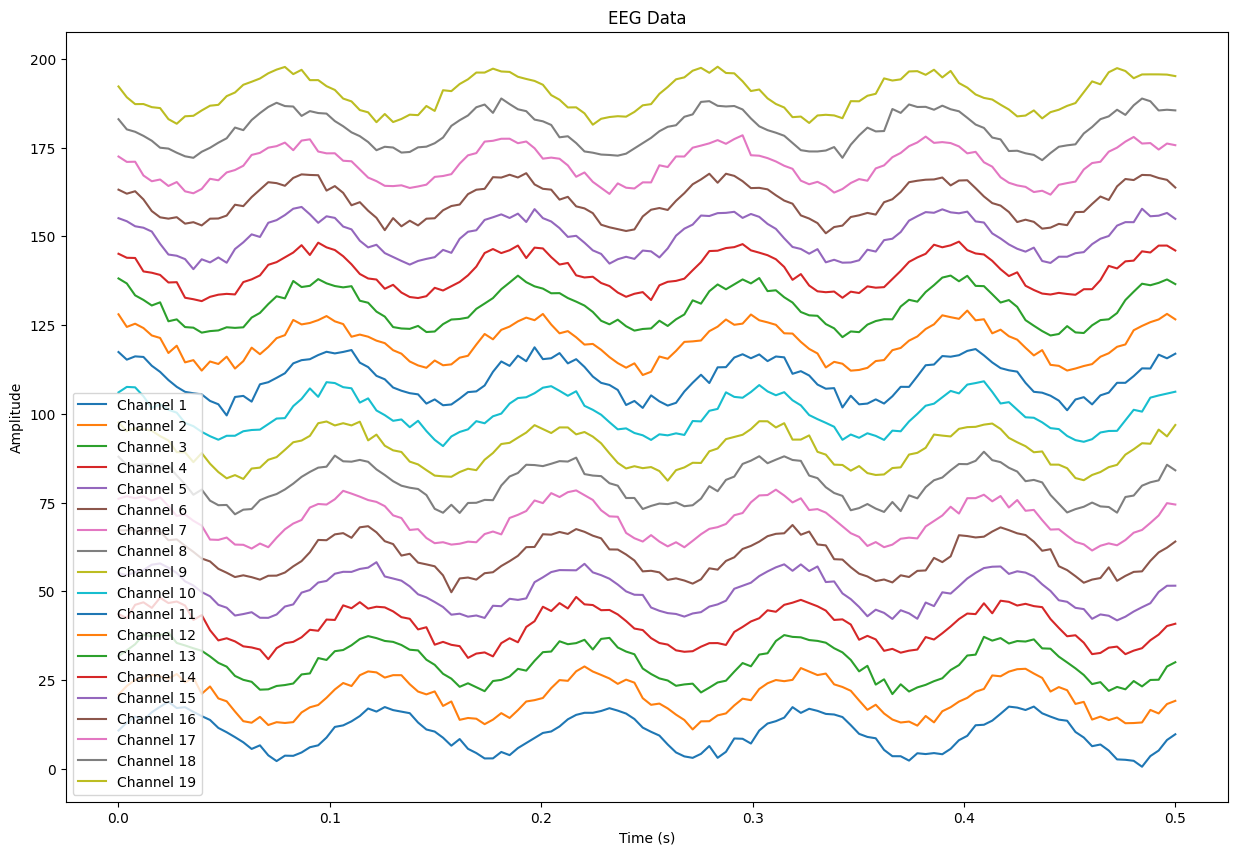

Irrev-- linear phase increment alpha with noise!: 0.009866506204784678


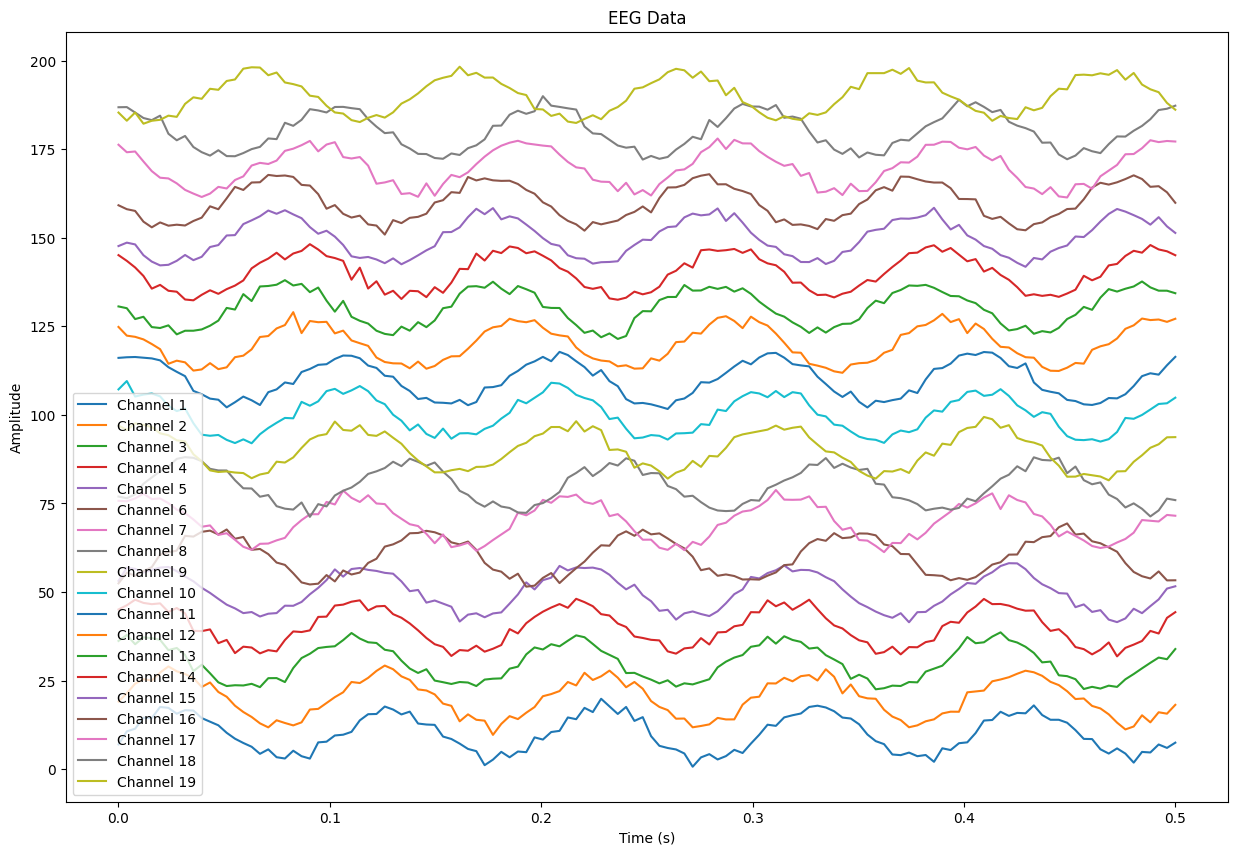

Irrev-- random phase increment alpha with noise!: 0.00808822804315952


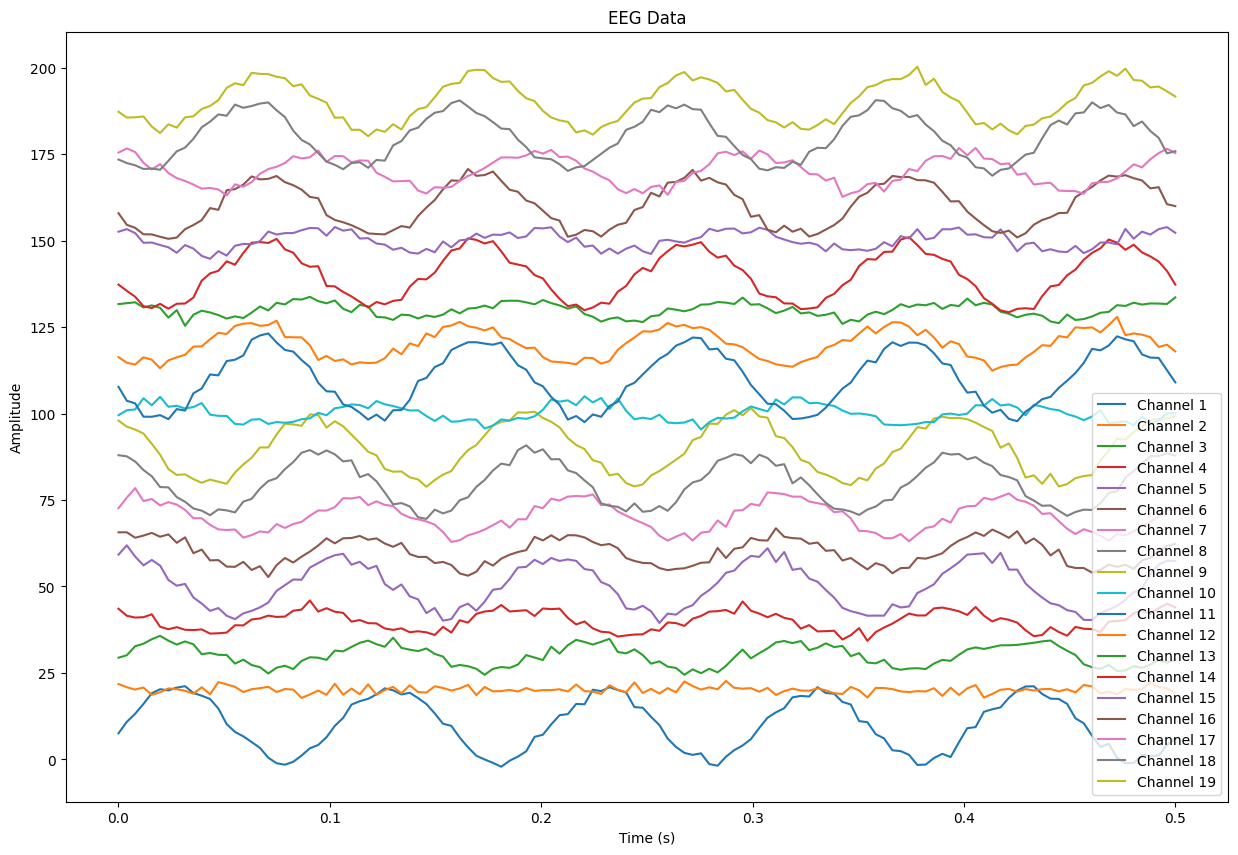

Irrev-- random phase increment alpha, random amplitude fluctuations, with noise!: 0.005289404750743429


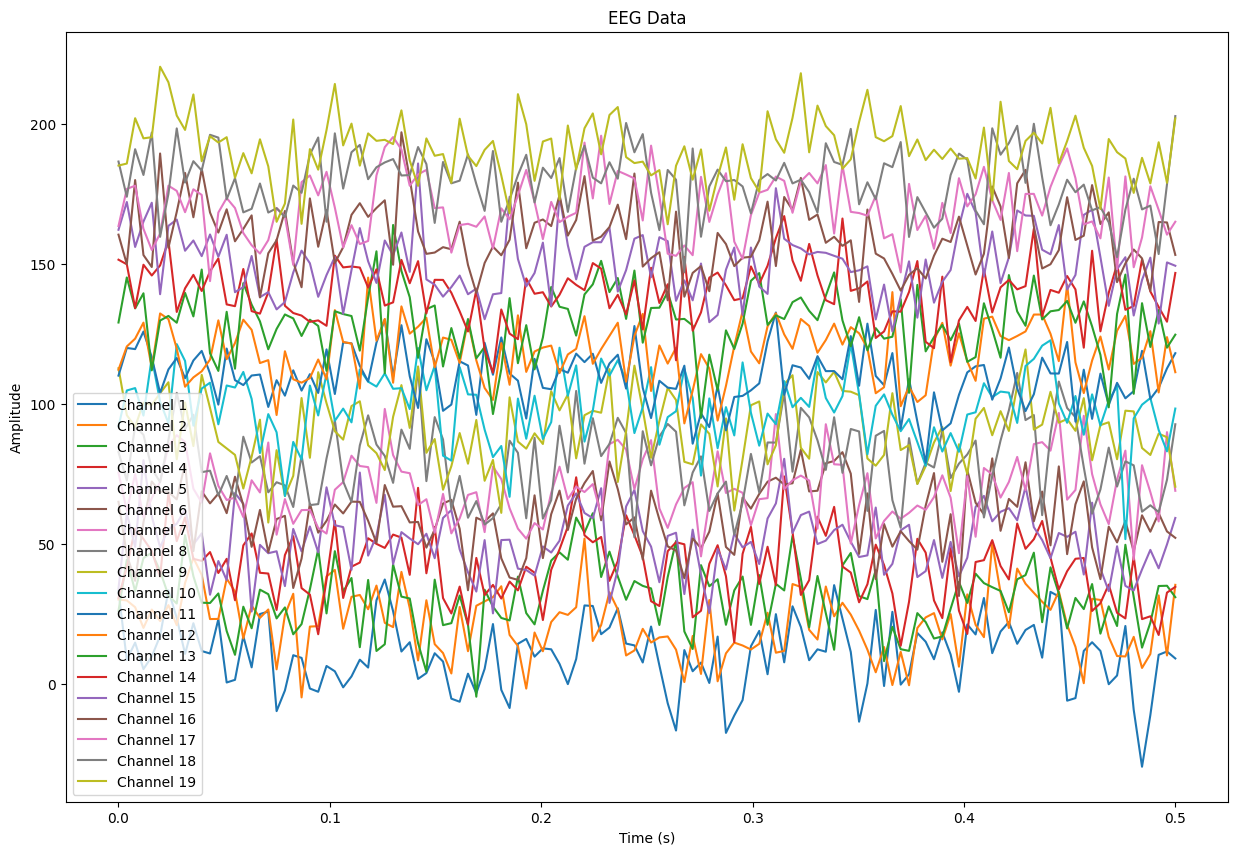

Irrev-- HUGE NOISE, no phase lag!: 0.0006064899958984964


In [26]:
from scipy.stats import pearsonr

import numpy as np
import matplotlib.pyplot as plt

def sine_func(fs, freq, amp, time, phase=0):
    samples = fs * time
    t = np.arange(samples)
    voltage = amp * np.sin(2 * np.pi * freq * t / fs + phase)
    return t, voltage


############### linear phase increment alpha without noise
fs = 256
timepoints = 128

freq = 10  # in Hz
amp = 7  # in arbitrary units (au)
duration = timepoints / fs  # in seconds
phase_increment = np.pi / 19  # Phase increment for each channel

all_alpha = np.zeros((19, timepoints))

for i in range(19):
    _, sine = sine_func(fs, freq, amp, duration, phase=i * phase_increment)
    sine = sine + 10  # add a DC offset
    all_alpha[i, :] = sine

time = np.linspace(0, timepoints / fs, timepoints)

# Plotting
plt.figure(figsize=(15, 10))
for i in range(19):
    plt.plot(time, all_alpha[i] + i * 10, label=f'Channel {i+1}')  # Offset each channel for clarity

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data')
plt.legend()
plt.show()

def autocorrelation(x, max_lag):
    """ Compute autocorrelation using NumPy for a given max_lag """
    autocorr = np.correlate(x - np.mean(x), x - np.mean(x), mode='full')
    autocorr = autocorr[autocorr.size // 2:]  # Take the second half
    autocorr /= autocorr[0]  # Normalize
    return autocorr[:max_lag + 1]

max_lag = 25
autocorrs = np.array([autocorrelation(channel, max_lag) for channel in all_alpha])
mean_autocorr = np.mean(autocorrs, axis=0)

# Plot the average autocorrelation function
plt.figure(figsize=(10, 5))
plt.plot(mean_autocorr, marker='o', linestyle='-')
plt.title('Average Autocorrelation of Alpha Waves Across 19 Channels')
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.grid(True)
plt.show()

tau = 13
n_channels = 19

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = all_alpha
rev_data = np.flip(forw_data, 1)


for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:timepoints-tau], forw_data[j,tau:timepoints])
      y = pearsonr(rev_data[i,0:timepoints-tau], rev_data[j,tau:timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = ((Forw - Rev)**2)
irrev = np.mean(ref_matrix)
print("Irrev-- linear phase increment alpha without noise!: " + str(irrev))


##################### perfect zero phase lag alpha no noise!
fs = 256
timepoints = 128

freq = 10  # in Hz
amp = 7  # in arbitrary units (au)
duration = timepoints / fs  # in seconds
phase_increment = np.pi / 19  # Phase increment for each channel

all_alpha = np.zeros((19, timepoints))

for i in range(19):
    _, sine = sine_func(fs, freq, amp, duration, phase=0)
    sine = sine + 10  # add a DC offset
    all_alpha[i, :] = sine

# Plotting
plt.figure(figsize=(15, 10))
for i in range(19):
    plt.plot(time, all_alpha[i] + i * 10, label=f'Channel {i+1}')  # Offset each channel for clarity

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data')
plt.legend()
plt.show()

tau = 13
n_channels = 19

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = all_alpha
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:timepoints-tau], forw_data[j,tau:timepoints])
      y = pearsonr(rev_data[i,0:timepoints-tau], rev_data[j,tau:timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = ((Forw - Rev)**2)
irrev = np.mean(ref_matrix)
print("Irrev-- perfect zero phase lag alpha no noise!: " + str(irrev))

##################### linear phase increment alpha with noise
fs = 256
timepoints = 128

freq = 10  # in Hz
amp = 7  # in arbitrary units (au)
duration = timepoints / fs  # in seconds
phase_increment = np.pi / 19  # Phase increment for each channel

all_alpha = np.zeros((19, timepoints))

for i in range(19):
    _, sine = sine_func(fs, freq, amp, duration, phase=i * phase_increment)
    sine = sine + 10  # add a DC offset
    all_alpha[i, :] = sine + np.random.randn(timepoints)

# Plotting
plt.figure(figsize=(15, 10))
for i in range(19):
    plt.plot(time, all_alpha[i] + i * 10, label=f'Channel {i+1}')  # Offset each channel for clarity

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data')
plt.legend()
plt.show()

tau = 13
n_channels = 19

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = all_alpha
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:timepoints-tau], forw_data[j,tau:timepoints])
      y = pearsonr(rev_data[i,0:timepoints-tau], rev_data[j,tau:timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = ((Forw - Rev)**2)
irrev = np.mean(ref_matrix)
print("Irrev-- linear phase increment alpha with noise!: " + str(irrev))

##################### random phase increment alpha with noise
fs = 256
timepoints = 128

freq = 10  # in Hz
amp = 7  # in arbitrary units (au)
duration = timepoints / fs  # in seconds
phase_increment = np.pi / 19  # Phase increment for each channel

all_alpha = np.zeros((19, timepoints))

for i in range(19):
    _, sine = sine_func(fs, freq, amp, duration, phase=i * phase_increment - np.random.randn())
    sine = sine + 10  # add a DC offset
    all_alpha[i, :] = sine + np.random.randn(timepoints)

# Plotting
plt.figure(figsize=(15, 10))
for i in range(19):
    plt.plot(time, all_alpha[i] + i * 10, label=f'Channel {i+1}')  # Offset each channel for clarity

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data')
plt.legend()
plt.show()

tau = 13
n_channels = 19

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = all_alpha
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:timepoints-tau], forw_data[j,tau:timepoints])
      y = pearsonr(rev_data[i,0:timepoints-tau], rev_data[j,tau:timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = ((Forw - Rev)**2)
irrev = np.mean(ref_matrix)
print("Irrev-- random phase increment alpha with noise!: " + str(irrev))



##################### random phase increment alpha, random amplitude fluctuations, with noise
fs = 256
timepoints = 128

freq = 10  # in Hz
amp = 7  # in arbitrary units (au)
duration = timepoints / fs  # in seconds
phase_increment = np.pi / 19  # Phase increment for each channel

all_alpha = np.zeros((19, timepoints))

for i in range(19):
    _, sine = sine_func(fs, freq, amp + (np.random.randn()*3), duration, phase=i * phase_increment - np.random.randn())
    sine = sine + 10  # add a DC offset
    all_alpha[i, :] = sine + np.random.randn(timepoints)

# Plotting
plt.figure(figsize=(15, 10))
for i in range(19):
    plt.plot(time, all_alpha[i] + i * 10, label=f'Channel {i+1}')  # Offset each channel for clarity

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data')
plt.legend()
plt.show()

tau = 13
n_channels = 19

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = all_alpha
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:timepoints-tau], forw_data[j,tau:timepoints])
      y = pearsonr(rev_data[i,0:timepoints-tau], rev_data[j,tau:timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = ((Forw - Rev)**2)
irrev = np.mean(ref_matrix)
print("Irrev-- random phase increment alpha, random amplitude fluctuations, with noise!: " + str(irrev))


##################### HUGE NOISE, no phase lag
fs = 256
timepoints = 128

freq = 10  # in Hz
amp = 7  # in arbitrary units (au)
duration = timepoints / fs  # in seconds
phase_increment = np.pi / 19  # Phase increment for each channel

all_alpha = np.zeros((19, timepoints))

for i in range(19):
    _, sine = sine_func(fs, freq, amp, duration, phase=0)
    sine = sine + 10  # add a DC offset
    all_alpha[i, :] = sine + (np.random.randn(timepoints)*10)

# Plotting
plt.figure(figsize=(15, 10))
for i in range(19):
    plt.plot(time, all_alpha[i] + i * 10, label=f'Channel {i+1}')  # Offset each channel for clarity

plt.xlabel('Time (s)')
plt.ylabel('Amplitude')
plt.title('EEG Data')
plt.legend()
plt.show()

tau = 13
n_channels = 19

Forw = np.zeros((n_channels, n_channels))
Rev = np.zeros((n_channels, n_channels))

forw_data = all_alpha
rev_data = np.flip(forw_data, 1)

for i in range(n_channels):
    for j in range(n_channels):
      x = pearsonr(forw_data[i,0:timepoints-tau], forw_data[j,tau:timepoints])
      y = pearsonr(rev_data[i,0:timepoints-tau], rev_data[j,tau:timepoints])
      Forw[i,j] = x[0]
      Rev[i,j] = y[0]
Forw = -1/2 * np.log(1 - (Forw**2))
Rev = -1/2 * np.log(1 - (Rev**2))
ref_matrix = ((Forw - Rev)**2)
irrev = np.mean(ref_matrix)
print("Irrev-- HUGE NOISE, no phase lag!: " + str(irrev))